# Batch reactor A + B → C: ODE and index‑1 DAE formulations

## Problem description
We model a closed, isothermal batch reactor with second‑order kinetics:

$$
\ce{A + B -> C}
$$

The reaction rate is:
$$
r = k\,C_A\,C_B
$$

We present and compare two equivalent mathematical formulations:

- **ODE formulation:** a single differential equation for $C_A(t)$, with $C_B(t)$ and $C_C(t)$ recovered from stoichiometric (algebraic) balances.
- **Index‑1 DAE formulation:** one differential equation for $C_A(t)$ and two algebraic equations enforcing the mass balances for $C_B(t)$ and $C_C(t)$.

---

## ODE formulation

The ODE formulation advances $C_A(t)$ using the reaction rate, and recovers $C_B(t)$ and $C_C(t)$ from the stoichiometry of $\ce{A + B -> C}$:

- Differential equation:
  $$
  \frac{dC_A}{dt} = -\,k\,C_A\,C_B
  $$
- Algebraic balances (reconstruction):
  $$
  \begin{aligned}
  C_B(t) &= C_{B0} - \big(C_{A0} - C_A(t)\big), \\
  C_C(t) &= C_{C0} + \big(C_{A0} - C_A(t)\big).
  \end{aligned}
  $$

Interpretation:
- $C_B$ decreases exactly by the amount of $C_A$ consumed.
- $C_C$ increases exactly by the amount of $C_A$ consumed.
- Only $C_A(t)$ is integrated; $C_B(t)$ and $C_C(t)$ remain consistent via the balances.

---

## Index‑1 DAE formulation

The DAE formulation makes the algebraic balances explicit constraints and treats $C_A$ as the sole differential variable:

- Differential residual:
  $$
    f_1 = -\,k\,C_A\,C_B
  $$

- Algebraic residuals:
  $$
  \begin{aligned}
    f_2 &= C_B - \Big[C_{B0} - \big(C_{A0} - C_A\big)\Big], \\
  f_3 &= C_C - \Big[C_{C0} + \big(C_{A0} - C_A\big)\Big]. \quad \text{}
  \end{aligned}
  $$
- Mass matrix:
  $$
  M = \begin{bmatrix}
  1 & 0 & 0 \\
  0 & 0 & 0 \\
  0 & 0 & 0
  \end{bmatrix}
  $$
so that the system is:

 $$M\,\dot{\mathbf{y}} = \mathbf{f}(t,\mathbf{y})$$ with $\mathbf{y} = [C_A,\,C_B,\,C_C]^T$ and $C_A$ as the differential variable.

Interpretation:
- The solver enforces $f_2 = 0$ and $f_3 = 0$ at all times, keeping $C_B$ and $C_C$ consistent with stoichiometry.
- The single differential equation $f_1$ drives the dynamics via $C_A$.
- This is a semi‑explicit index‑1 DAE: one differential state and two algebraic constraints.

---

### Why show both?

- The **ODE** formulation is compact and efficient when balances are simple; it reduces dimensionality and is often easier to solve.
- The **DAE** formulation is clearer when multiple constraints must be enforced (e.g., electroneutrality, phase equilibrium, or coupling to unit operations). It mirrors how many process models are written and checked.
- Solving both and comparing results help students verify numerical consistency: the trajectories should match, and algebraic residuals should stay near zero throughout.

**References**:
- Hairer, E., Wanner, G. Solving Ordinary Differential Equations II: Stiff and Differential‑Algebraic Problems. Springer, 1996.
- David Clough, Matlab Bootcamp

## 📦 Import required packages

In [1]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

## Model parameters

In [2]:
# Parameters
factor = 10               # stiffness factor (increase to make system more stiff)
k   = 14.7 * factor       # reaction rate constant [1/(mol/L)/min]
Ca0 = 0.0209              # initial concentration of A [mol/L]
Cb0 = Ca0 / 3.0           # initial concentration of B [mol/L]
Cc0 = 0.0                 # initial concentration of C [mol/L]

In [3]:
# Time span
t0, tf=0, 5                    # min
t_span = (t0, tf)
t_eval = np.linspace(*t_span, 201)

## ODE Approach

In [4]:
def batch_reactor_ode(t, y):
    """
    ODE in Ca(t) for A + B -> C with algebraic recovery of Cb and Cc.

    Parameters
    ----------
    t : float
        Current time [min].
    y : array_like, shape (1,)
        State vector [Ca].

    Returns
    -------
    dydt : ndarray, shape (1,)
        dCa/dt = -k * Ca * Cb, where Cb = Cb0 - (Ca0 - Ca).
    """
    Ca = y[0]
    Cb = Cb0 - (Ca0 - Ca)
    dCadt = -k * Ca * Cb
    return np.array([dCadt])

## 🚀 Solve ODE with BDF from Scipy

In [5]:
# Solve using a stiff implicit method (BDF to match user's preference)
sol_ode = solve_ivp(fun=batch_reactor_ode,
                    t_span=t_span, y0=[Ca0],
                    method='BDF', t_eval=t_eval,
                    rtol=1e-8, atol=1e-10, dense_output=True)

In [6]:
# Extract solution and reconstruct B, C
t  = sol_ode.t
Ca = sol_ode.y[0]
Cb = Cb0 - (Ca0 - Ca)
Cc = Cc0 + (Ca0 - Ca)

### Plot ODE results

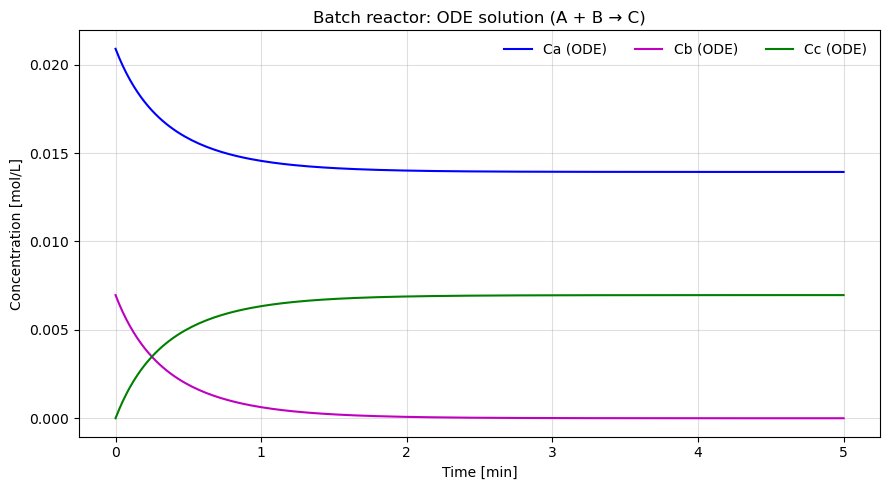

In [7]:
plt.figure(figsize=(9,5))
plt.plot(t, Ca, 'b-', label='Ca (ODE)')
plt.plot(t, Cb, 'm-', label='Cb (ODE)')
plt.plot(t, Cc, 'g-', label='Cc (ODE)')
plt.xlabel('Time [min]')
plt.ylabel('Concentration [mol/L]')
plt.title('Batch reactor: ODE solution (A + B → C)')
plt.legend(ncol=3, frameon=False)
plt.grid(True, alpha=0.4)
plt.tight_layout()
plt.show()

## DAE Approach

In [8]:
def batch_reactor_dae(t, y):
    """
    Semi-explicit index-1 DAE for A + B -> C with mass balances enforced.

      y = [Ca, Cb, Cc]
      f1 = -k * Ca * Cb                               (differential)
      f2 = Cb - (Cb0 - (Ca0 - Ca))                    (algebraic balance for B)
      f3 = Cc - (Cc0 + (Ca0 - Ca))                    (algebraic balance for C)

    Such that M y' = f(t, y) with M = diag([1, 0, 0]).
    """
    Ca, Cb, Cc = y
    eq1 = -k * Ca * Cb
    eq2 = Cb - (Cb0 - (Ca0 - Ca))
    eq3 = Cc - (Cc0 + (Ca0 - Ca))
    return np.array([eq1, eq2, eq3])

In [9]:
def jac_dae(t, y):
    """
    Jacobian df/dy to accelerate Newton iterations:

      df1/dCa = -k*Cb,   df1/dCb = -k*Ca,  df1/dCc = 0
      df2/dCa = +1,      df2/dCb =  1,     df2/dCc = 0
      df3/dCa = -1,      df3/dCb =  0,     df3/dCc = 1
    """
    Ca, Cb, Cc = y
    return np.array([
        [-k*Cb, -k*Ca, 0.0],
        [1.0,   1.0,   0.0],
        [-1.0,  0.0,   1.0]
    ])

### RadauDAE solver setup

In [10]:
from radauDAE import RadauDAE
method = RadauDAE

# Mass matrix and variable indices
mass_matrix = np.array([
    [1.0, 0.0, 0.0],   # Ca: differential
    [0.0, 0.0, 0.0],   # Cb: algebraic
    [0.0, 0.0, 0.0]    # Cc: algebraic
])
var_index = np.array([0, 1, 1])

# Initial conditions (consistent with balances)
y0 = np.array([Ca0, Cb0, Cc0])

### Call RadauDAE solver

In [11]:
# Solve the DAE
sol_dae = solve_ivp(fun=batch_reactor_dae,
                    t_span=t_span,
                    y0=y0,
                    method=method,
                    mass_matrix=mass_matrix,
                    var_index=var_index,
                    jac=jac_dae,
                    rtol=1e-8, atol=1e-10,
                    t_eval=t_eval,
                    dense_output=True,
                    bPrint=False)

In [12]:
# Extract DAE solution
t_d  = sol_dae.t
Ca_d = sol_dae.y[0]
Cb_d = sol_dae.y[1]
Cc_d = sol_dae.y[2]

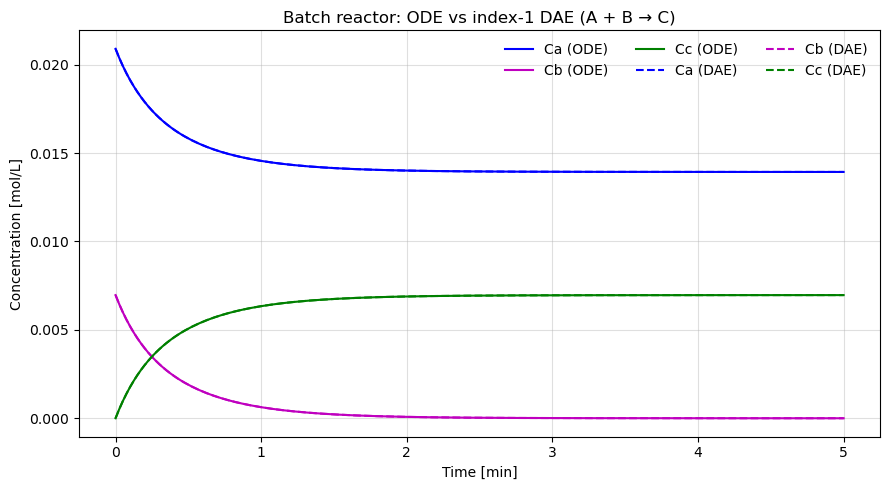

In [13]:
# Plot DAE results and overlay ODE for comparison
plt.figure(figsize=(9,5))
plt.plot(t,   Ca,  'b-',  label='Ca (ODE)')
plt.plot(t,   Cb,  'm-',  label='Cb (ODE)')
plt.plot(t,   Cc,  'g-',  label='Cc (ODE)')
plt.plot(t_d, Ca_d,'b--', label='Ca (DAE)')
plt.plot(t_d, Cb_d,'m--', label='Cb (DAE)')
plt.plot(t_d, Cc_d,'g--', label='Cc (DAE)')
plt.xlabel('Time [min]')
plt.ylabel('Concentration [mol/L]')
plt.title('Batch reactor: ODE vs index-1 DAE (A + B → C)')
plt.legend(ncol=3, frameon=False)
plt.grid(True, alpha=0.4)
plt.tight_layout()
plt.show()

## 📊 Solver statistics

In [14]:
for sol, name in ((sol_dae, 'DAE (RadauDAE)'), (sol_ode, 'ODE (BDF)')):
    state = 'solved' if sol.success else 'failed'
    print(f"\n{name} {state}")
    print(f"  steps={sol.t.size-1}")
    print(f"  nfev={sol.nfev}, njev={sol.njev}, nlu={sol.nlu}")
    print(f"  message: {sol.message}")


DAE (RadauDAE) solved
  steps=200
  nfev=44949, njev=1959, nlu=7150
  message: The solver successfully reached the end of the integration interval.

ODE (BDF) solved
  steps=200
  nfev=397, njev=1, nlu=29
  message: The solver successfully reached the end of the integration interval.


## 🔍 Validation and comparison: DAE vs ODE results

In this section we check how closely the Differential-Algebraic Equation (DAE) solution
matches the Ordinary Differential Equation (ODE) solution. We do this in two ways:

1. Max-norm agreement: compute the maximum absolute difference between Ca, Cb, Cc
   from the ODE and DAE formulations on the same time grid.
2. Invariant residuals: verify that the algebraic balances for B and C are satisfied.
   These residuals should remain close to zero if the solver correctly enforces constraints.

In [15]:
# Max-norm agreement on the same t_eval grid
err_Ca = np.linalg.norm(Ca - Ca_d, ord=np.inf)
err_Cb = np.linalg.norm(Cb - Cb_d, ord=np.inf)
err_Cc = np.linalg.norm(Cc - Cc_d, ord=np.inf)

# Invariant residuals (should be near zero)
inv_B_ode = Cb - (Cb0 - (Ca0 - Ca))       # ODE balance for B
inv_C_ode = Cc - (Cc0 + (Ca0 - Ca))       # ODE balance for C
inv_B_dae = Cb_d - (Cb0 - (Ca0 - Ca_d))   # DAE balance for B
inv_C_dae = Cc_d - (Cc0 + (Ca0 - Ca_d))   # DAE balance for C

# Print agreement results
print(f"[Agreement] max|Ca_ODE - Ca_DAE| = {err_Ca:.3e}")
print(f"[Agreement] max|Cb_ODE - Cb_DAE| = {err_Cb:.3e}")
print(f"[Agreement] max|Cc_ODE - Cc_DAE| = {err_Cc:.3e}")

# Print invariant residuals
print(f"[Invariant ODE] max residual B-balance = {np.linalg.norm(inv_B_ode, np.inf):.3e}")
print(f"[Invariant ODE] max residual C-balance = {np.linalg.norm(inv_C_ode, np.inf):.3e}")
print(f"[Invariant DAE] max residual B-balance = {np.linalg.norm(inv_B_dae, np.inf):.3e}")
print(f"[Invariant DAE] max residual C-balance = {np.linalg.norm(inv_C_dae, np.inf):.3e}")

[Agreement] max|Ca_ODE - Ca_DAE| = 6.872e-10
[Agreement] max|Cb_ODE - Cb_DAE| = 6.872e-10
[Agreement] max|Cc_ODE - Cc_DAE| = 6.872e-10
[Invariant ODE] max residual B-balance = 0.000e+00
[Invariant ODE] max residual C-balance = 0.000e+00
[Invariant DAE] max residual B-balance = 1.294e-14
[Invariant DAE] max residual C-balance = 1.294e-14
